In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
seed = 1234

# 1. Classification and hold-out
## 1.1 Load 'abalone' dataset 

In [2]:
# Load labels
ds = np.loadtxt('abalone.csv')
X = ds[:,:-1]
y_truth = ds[:,-1]

# Count items for each class
np.unique(y_truth, return_counts=True)

(array([0., 1., 2.]), array([1306, 1342,  416]))

## 1.2 Create train and test splits
- Use the train_test_split() method
- Random state to make results repeatable

In [3]:
# Separate data into training and test set
# Default test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y_truth, 
                                                    test_size=0.2, random_state=seed)


## 1.3 Train classifier and make predictions
- Use Gaussian Naive Bayes classifier

In [4]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

## 1.4 Evaluate the results
- Evaluation using accuracy score

In [5]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Compute accuracy
acc = accuracy_score(y_test, y_test_pred)
print(f"Accuracy = {acc:.2f}")

Accuracy = 0.69


- **Accuracy** seems good, but if we look at the scores separately for each class...

In [6]:
# Precision, recall, f1, support: for each class
p, r, f1, support = precision_recall_fscore_support(y_test, y_test_pred)

for c in range(p.shape[0]):
    print(f"\nClass {c}:")
    print(f"number of items: {support[c]}")
    print(f"p = {p[c]:.2f}")
    print(f"r = {r[c]:.2f}")
    print(f"f1 = {f1[c]:.2f}")

# Macro average f1
macro_f1 = f1.mean()    
    
# This score is important when you have class imbalancing
print(f"\nF1, macro-average: {macro_f1:2f}")


Class 0:
number of items: 262
p = 0.70
r = 0.73
f1 = 0.72

Class 1:
number of items: 272
p = 0.70
r = 0.85
f1 = 0.77

Class 2:
number of items: 79
p = 0.00
r = 0.00
f1 = 0.00

F1, macro-average: 0.494383


- Accuracy was good because of class imbalancing
- The **minority class** (c2) has a very low recall
- Indeed, the **macro-averaged** F1 is quite low.

### Let's verify this with a confusion matrix:

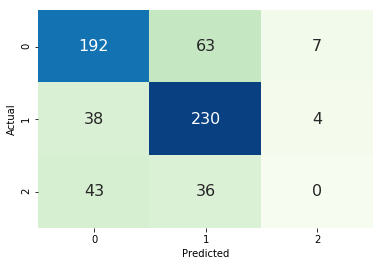

In [7]:
# Build the confusion matrix
conf_mat = confusion_matrix(y_test, y_test_pred)

# Plot the result
label_names = np.arange(p.shape[0])
conf_mat_df = pd.DataFrame(conf_mat, index = label_names, columns = label_names)
conf_mat_df.index.name = 'Actual'
conf_mat_df.columns.name = 'Predicted'
sns.heatmap(conf_mat_df, annot=True, cmap='GnBu', 
            annot_kws={"size": 16}, fmt='g', cbar=False)
plt.show()

# 2. Cross-Validation
##  2.1 With kfold.split()

In [8]:
from sklearn.model_selection import KFold
# K-Fold with 5 splits
kfold = KFold(n_splits=5, shuffle=True)

print("Scores for each kfold iteration.")
i = 0
for train_indices, test_indices in kfold.split(X, y_truth):
    # Prepare splits
    X_train = X[train_indices]     # Use fancy indexing to extract data
    y_train = y_truth[train_indices]
    X_test = X[test_indices]
    y_test = y_truth[test_indices]
    
    # Train and evaluate
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    
    # Compute macro average f1
    _, _, f1, _ = precision_recall_fscore_support(y_test, y_test_pred)
    macro_f1 = f1.mean()
    
    print(f"Iteration {i}. macro-f1 = {macro_f1}")
    i+=1

Scores for each kfold iteration.
Iteration 0. macro-f1 = 0.49840888571579905
Iteration 1. macro-f1 = 0.5060872254957444
Iteration 2. macro-f1 = 0.4881514943991685
Iteration 3. macro-f1 = 0.5148031091091589
Iteration 4. macro-f1 = 0.5251948797055165


## 2.2 With cross_val_score()
- Use scoring = 'f1_macro'

In [9]:
from sklearn.model_selection import cross_val_score

In [10]:
clf = GaussianNB()
f1_cv = cross_val_score(clf, X, y_truth, cv=5, scoring='f1_macro')

In [11]:
print(f"Macro-f1 for each iteration: {f1_cv}")
mean_macro_f1 = f1_cv.mean()
std_macro_f1 = f1_cv.std() * 2
print(f"Macro-f1 (statistics): {mean_macro_f1:.2f} (+/- {std_macro_f1:.2f})")

Macro-f1 for each iteration: [0.50569809 0.49595096 0.50625287 0.52250948 0.51496524]
Macro-f1 (statistics): 0.51 (+/- 0.02)


## 2.3 Leave-One-Out and scoring: cross_val_predict()

- The previous approach (average of F1 for each iteration) cannot be used with leave one out. 
    - Iteration 0: y_test = [1] -> F1?
    - Iteration 1: y_test = [0] -> F1?
    - ...
    - Iteration 2: y_test = [1] -> F1?
- When test set has only 1 sample, F1, precision and recall cannot be properly computed.
- The following solution trains N models with leave one out, fits them on test data to obtain the vector y_pred (each model predicts 1 single value inside y_pred). Finally, it computes a single score by comparing y_pred with y_truth

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut

clf = GaussianNB()
y_pred = cross_val_predict(clf, X, y_truth, cv=LeaveOneOut())
_, _, f1_loo, _ = precision_recall_fscore_support(y_truth, y_pred)
macro_f1_loo = f1_loo.mean()
print(f"F1, for each class: {f1_loo}")
print(f"Macro-f1 = {macro_f1_loo:.2f}")

F1, for each class: [0.71562952 0.76223533 0.04968944]
Macro-f1 = 0.51
